In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset

# load the data
medical_ner_data = load_dataset("ktgiahieu/maccrobat2018_2020")
print(medical_ner_data)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 400
    })
})


In [2]:
import random

# Set seed for reproducibility
random.seed(42)

# Get random indices
num_examples = len(medical_ner_data['train'])
random_indices = random.sample(range(num_examples), 3)

print("DATASET SAMPLES")
print("="*100)

for sample_num, idx in enumerate(random_indices, 1):
    example = medical_ner_data['train'][idx]
    tokens = example['tokens']
    tags = example['tags']
    
    print(f"\nSAMPLE {sample_num}")
    print("="*100)

    # Debugging: Print tokens and tags for a specific sample
    print("Tokens:", example['tokens'])
    print("Tags:", example['tags'])
    
    # Reconstruct text
    text = ''
    for token in tokens:
        if token in [',', '.', '!', '?', ';', ':', ')', '-']:
            text += token
        elif text and not text.endswith(' '):
            text += ' ' + token
        else:
            text += token
    
    print(f"Text:\n{text}\n")
    
    # Extract entities in order
    print("Entities:")
    entities = []
    i = 0
    while i < len(tags):
        if tags[i].startswith('B-'):
            entity_type = tags[i].split('-')[1]
            span_tokens = [tokens[i]]
            j = i + 1
            
            # Check for continuation of the entity
            while j < len(tags) and tags[j].startswith('I-') and tags[j].split('-')[1] == entity_type:
                span_tokens.append(tokens[j])
                j += 1
            
            # Add the entity to the list
            span_text = ' '.join(span_tokens)
            entities.append((span_text, entity_type))
            i = j
        else:
            i += 1

    if entities:
        for entity_text, entity_type in entities:
            print(f"  • {entity_text:<40} → {entity_type}")
    else:
        print("  (No entities)")

print(f"\n{'='*100}")

DATASET SAMPLES

SAMPLE 1
Tokens: ['A', '67', '-', 'year', '-', 'old', 'Japanese', 'female', 'presented', 'with', 'a', 'left', 'buttock', 'tumor', ',', 'which', 'had', 'been', 'first', 'detected', 'approximately', '1', 'year', 'earlier', ',', 'and', 'had', 'recently', 'gradually', 'enlarged', '.', '\n', 'Physical', 'examination', 'revealed', 'a', 'relatively', 'well', '-', 'circumscribed', 'skin', '-', 'colored', 'tumor', 'with', 'hyperkeratosis', ',', 'measuring', '43', 'x', '38', 'mm', 'in', 'diameter', ',', 'in', 'her', 'left', 'buttock', '.', '\n', 'The', 'biopsy', 'specimen', 'revealed', 'Bowen', '’s', 'disease', '(', 'squamous', 'cell', 'carcinoma', 'in', 'situ', ')', ',', 'and', 'subsequently', ',', 'total', 'resection', 'of', 'the', 'tumor', 'was', 'performed', '.', '\n', 'Histopathological', 'study', 'of', 'the', 'resected', 'specimen', 'revealed', 'proliferation', 'of', 'atypical', 'squamous', 'cells', 'in', 'the', 'entire', 'layer', 'of', 'the', 'acanthotic', 'epidermis', 'a

Entity Distribution Summary:
               Entity_Type  Count  Percentage               Tier
7     Diagnostic_procedure  11747       20.70   Frequent (>1000)
5             Sign_symptom   6563       11.56   Frequent (>1000)
10               Lab_value   6555       11.55   Frequent (>1000)
11    Biological_structure   5119        9.02   Frequent (>1000)
8     Detailed_description   3279        5.78   Frequent (>1000)
13                    Date   3050        5.37   Frequent (>1000)
3         Disease_disorder   2894        5.10   Frequent (>1000)
2                  History   2440        4.30   Frequent (>1000)
19   Therapeutic_procedure   2086        3.68   Frequent (>1000)
9               Medication   2070        3.65   Frequent (>1000)
0                      Age   1904        3.35   Frequent (>1000)
24                  Dosage   1473        2.60   Frequent (>1000)
6                 Duration   1189        2.09   Frequent (>1000)
4           Clinical_event   1091        1.92   Frequent (>10

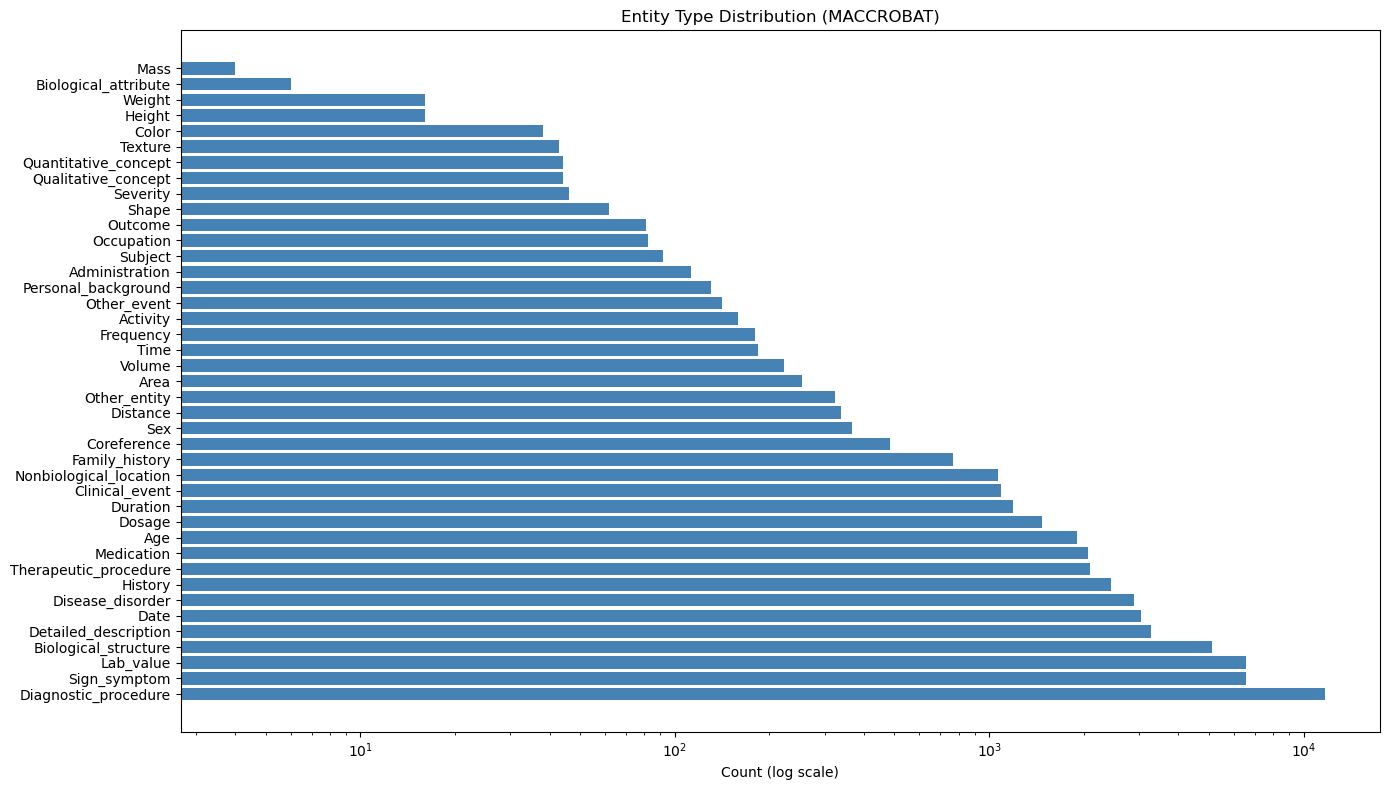

In [3]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
medical_ner_data = load_dataset("ktgiahieu/maccrobat2018_2020")
train_data = medical_ner_data['train']

# Count entities per type
entity_counts = Counter()
for example in train_data:
    tags = example['tags']
    for tag in tags:
        if tag != 'O':
            # Extract entity type (e.g., "B-Age" -> "Age")
            entity_type = tag.split('-')[1]
            entity_counts[entity_type] += 1

# Create dataframe
entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity_Type', 'Count'])
entity_df = entity_df.sort_values('Count', ascending=False)
entity_df['Percentage'] = (entity_df['Count'] / entity_df['Count'].sum() * 100).round(2)

# Categorize by frequency tier
def categorize_tier(count):
    if count > 1000:
        return 'Frequent (>1000)'
    elif count >= 100:
        return 'Medium (100-1000)'
    else:
        return 'Rare (<100)'

entity_df['Tier'] = entity_df['Count'].apply(categorize_tier)

print("Entity Distribution Summary:")
print(entity_df.to_string())
print("\nTier Breakdown:")
print(entity_df['Tier'].value_counts())

# Visualize (log scale for rare types)
fig, ax = plt.subplots(figsize=(14, 8))
ax.barh(entity_df['Entity_Type'], entity_df['Count'], color='steelblue')
ax.set_xscale('log')
ax.set_xlabel('Count (log scale)')
ax.set_title('Entity Type Distribution (MACCROBAT)')
plt.tight_layout()
plt.show()

Document-Level Statistics:
  Mean entities per doc: 66.72
  Median entities per doc: 66.00
  Std dev: 36.76
  Min: 4, Max: 187

Entity Type Coverage (% of docs containing type):
               Entity_Type  Coverage_%
10                     Age       98.00
0     Diagnostic_procedure       95.50
1             Sign_symptom       94.50
17                     Sex       91.50
6         Disease_disorder       90.00
3     Biological_structure       84.50
2                Lab_value       83.25
13          Clinical_event       81.75
5                     Date       77.00
4     Detailed_description       74.50
8    Therapeutic_procedure       73.00
9               Medication       72.00
14  Nonbiological_location       60.25
7                  History       57.00
12                Duration       55.00
16             Coreference       42.00
11                  Dosage       35.00
26     Personal_background       22.50
18                Distance       21.00
15          Family_history       16.75
30 

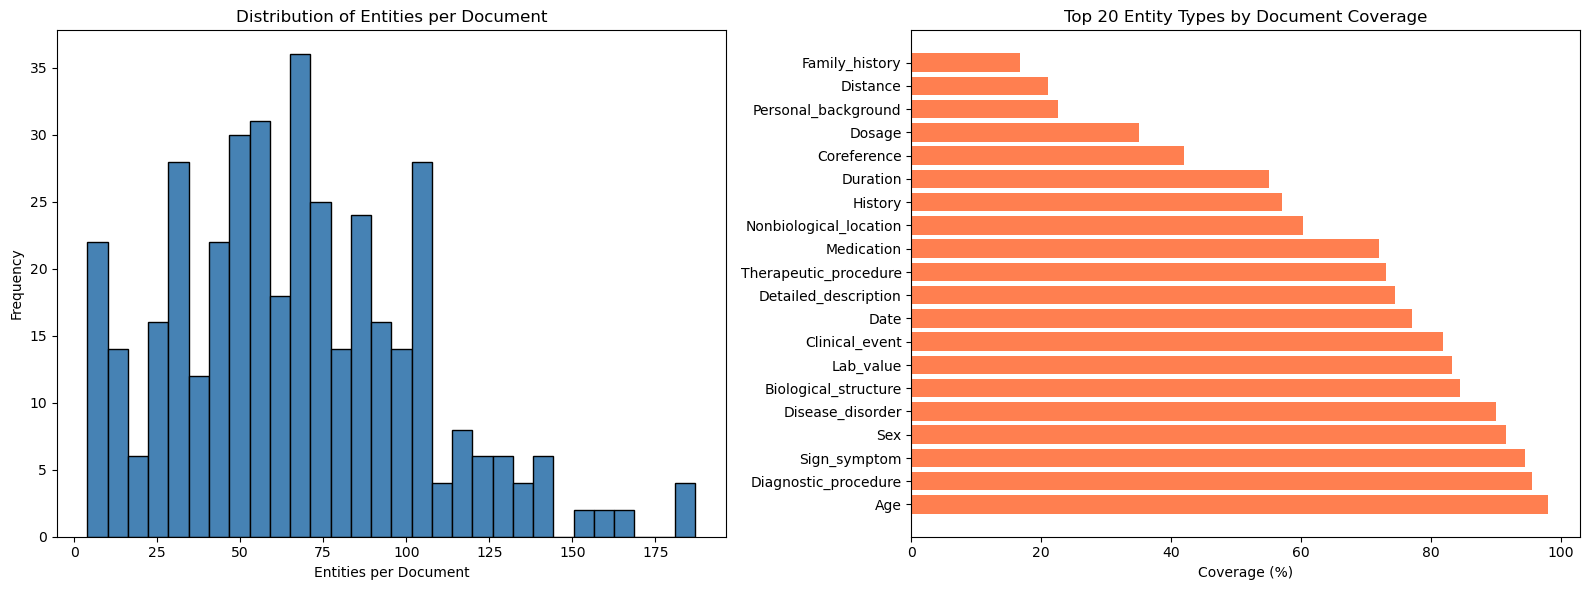

In [4]:
# Entities per document
entities_per_doc = []
for example in train_data:
    tags = example['tags']
    # Count entity beginnings (each B- tag is a new entity)
    entity_count = sum(1 for tag in tags if tag.startswith('B-'))
    entities_per_doc.append(entity_count)

entities_per_doc = np.array(entities_per_doc)

print("Document-Level Statistics:")
print(f"  Mean entities per doc: {entities_per_doc.mean():.2f}")
print(f"  Median entities per doc: {np.median(entities_per_doc):.2f}")
print(f"  Std dev: {entities_per_doc.std():.2f}")
print(f"  Min: {entities_per_doc.min()}, Max: {entities_per_doc.max()}")

# Coverage: % of documents with each entity type
coverage = {}
for entity_type in entity_df['Entity_Type']:
    docs_with_type = 0
    for example in train_data:
        tags = example['tags']
        tag_types = [tag.split('-')[1] for tag in tags if tag != 'O']
        if entity_type in tag_types:
            docs_with_type += 1
    coverage[entity_type] = (docs_with_type / len(train_data) * 100)

coverage_df = pd.DataFrame(coverage.items(), columns=['Entity_Type', 'Coverage_%'])
coverage_df = coverage_df.sort_values('Coverage_%', ascending=False)

print("\nEntity Type Coverage (% of docs containing type):")
print(coverage_df.to_string())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of entities per document
ax1.hist(entities_per_doc, bins=30, color='steelblue', edgecolor='black')
ax1.set_xlabel('Entities per Document')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Entities per Document')

# Coverage
ax2.barh(coverage_df['Entity_Type'][:20], coverage_df['Coverage_%'][:20], color='coral')
ax2.set_xlabel('Coverage (%)')
ax2.set_title('Top 20 Entity Types by Document Coverage')

plt.tight_layout()
plt.show()

Entity Length Analysis:
               Entity_Type  Avg_Length  Median_Length  Max_Length  Pct_MultiToken
19            Other_entity   23.071429           26.0          40      100.000000
15          Family_history    6.669565            5.0          28       94.782609
21                  Volume    5.842105            4.0          12      100.000000
7                  History    5.622120            4.0          23       82.488479
25             Other_event    5.222222            4.0          14       92.592593
20                    Area    5.080000            5.0           9      100.000000
10                     Age    4.760000            5.0           6       98.000000
11                  Dosage    4.114525            4.0          16       96.089385
4     Detailed_description    3.265936            2.0          22       74.103586
29              Occupation    3.153846            2.0           7       76.923077
5                     Date    3.068410            3.0          10       94

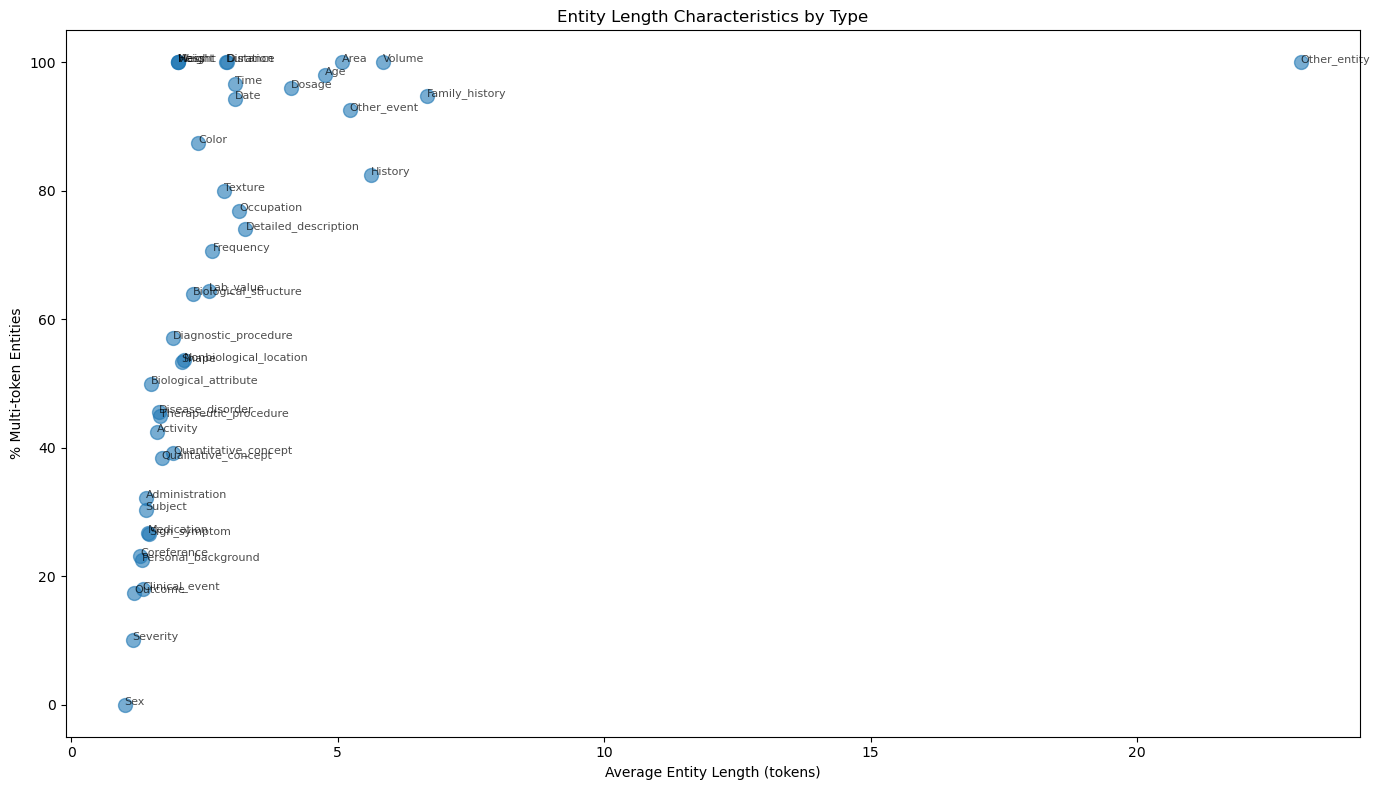

In [5]:
# Entity length (in tokens) per type
entity_lengths = {entity_type: [] for entity_type in entity_df['Entity_Type']}

for example in train_data:
    tokens = example['tokens']
    tags = example['tags']
    
    i = 0
    while i < len(tags):
        if tags[i].startswith('B-'):
            entity_type = tags[i].split('-')[1]
            length = 1  # Count B- token
            
            # Count consecutive I- tokens
            j = i + 1
            while j < len(tags) and tags[j].startswith('I-'):
                if tags[j].split('-')[1] == entity_type:
                    length += 1
                    j += 1
                else:
                    break
            
            entity_lengths[entity_type].append(length)
            i = j
        else:
            i += 1

# Summary stats per type
length_summary = []
for entity_type, lengths in entity_lengths.items():
    if lengths:
        length_summary.append({
            'Entity_Type': entity_type,
            'Avg_Length': np.mean(lengths),
            'Median_Length': np.median(lengths),
            'Max_Length': np.max(lengths),
            'Pct_MultiToken': (sum(1 for l in lengths if l > 1) / len(lengths) * 100)
        })

length_df = pd.DataFrame(length_summary).sort_values('Avg_Length', ascending=False)

print("Entity Length Analysis:")
print(length_df.to_string())

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(length_df['Avg_Length'], length_df['Pct_MultiToken'], s=100, alpha=0.6)
for idx, row in length_df.iterrows():
    ax.annotate(row['Entity_Type'], (row['Avg_Length'], row['Pct_MultiToken']), 
                fontsize=8, alpha=0.7)
ax.set_xlabel('Average Entity Length (tokens)')
ax.set_ylabel('% Multi-token Entities')
ax.set_title('Entity Length Characteristics by Type')
plt.tight_layout()
plt.show()

In [6]:
# For each rare type, collect all unique mentions
rare_types = entity_df[entity_df['Tier'] == 'Rare (<100)']['Entity_Type'].tolist()

rare_vocab = {}
for rare_type in rare_types:
    mentions = []
    for example in train_data:
        tokens = example['tokens']
        tags = example['tags']
        
        i = 0
        while i < len(tags):
            if tags[i].startswith('B-'):
                entity_type = tags[i].split('-')[1]
                if entity_type == rare_type:
                    mention_tokens = [tokens[i]]
                    j = i + 1
                    while j < len(tags) and tags[j].startswith('I-') and tags[j].split('-')[1] == rare_type:
                        mention_tokens.append(tokens[j])
                        j += 1
                    mentions.append(' '.join(mention_tokens))
                    i = j
                else:
                    i += 1
            else:
                i += 1
    
    rare_vocab[rare_type] = mentions

# Display rare type vocab
for rare_type in sorted(rare_types, key=lambda x: len(rare_vocab[x])):
    mentions = rare_vocab[rare_type]
    unique_mentions = len(set(mentions))
    print(f"\n{rare_type}: {len(mentions)} total, {unique_mentions} unique")
    print(f"  Examples: {list(set(mentions))[:5]}")


Mass: 2 total, 1 unique
  Examples: ['6.5 kg']

Biological_attribute: 4 total, 2 unique
  Examples: ['nucleoli', 'cytologic features']

Height: 8 total, 3 unique
  Examples: ['161 cm', '165 cm', '108 cm']

Weight: 8 total, 4 unique
  Examples: ['3132 g', '72 kg', '47 kg', '83 kg']

Texture: 15 total, 8 unique
  Examples: ['severely tender', 'cobble stone', 'smooth surface', 'classical " sandstorm " appearance', 'surrounding ground glass opacity']

Color: 16 total, 8 unique
  Examples: ['pale tan', 'homogenously white', 'coffee - colored', 'grayish - white', 'gray - white']

Quantitative_concept: 23 total, 16 unique
  Examples: ['42', '6/10', 'six times', '10–15 cigarettes per day', '20']

Occupation: 26 total, 13 unique
  Examples: ['student', 'college student', 'company worker', 'a dog breeder for 12 years', 'cotton farmer']

Qualitative_concept: 26 total, 12 unique
  Examples: ['high', 'improved', 'daytime only', 'normal', 'multiple']

Shape: 30 total, 13 unique
  Examples: ['nodula

In [7]:
from itertools import combinations

# Document-level co-occurrence matrix
cooccurrence = {}
for example in train_data:
    tags = example['tags']
    # Get all entity types in this document
    types_in_doc = set()
    for tag in tags:
        if tag != 'O':
            entity_type = tag.split('-')[1]
            types_in_doc.add(entity_type)
    
    # Record all pairs
    for pair in combinations(sorted(types_in_doc), 2):
        key = tuple(pair)
        cooccurrence[key] = cooccurrence.get(key, 0) + 1

# Top co-occurring pairs
top_pairs = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Entity Type Co-occurrence Patterns:")
for (type1, type2), count in top_pairs:
    print(f"  {type1} + {type2}: {count} documents")

Top 20 Entity Type Co-occurrence Patterns:
  Age + Diagnostic_procedure: 376 documents
  Age + Sign_symptom: 370 documents
  Diagnostic_procedure + Sign_symptom: 368 documents
  Age + Sex: 364 documents
  Age + Disease_disorder: 352 documents
  Diagnostic_procedure + Disease_disorder: 348 documents
  Diagnostic_procedure + Sex: 348 documents
  Disease_disorder + Sign_symptom: 348 documents
  Sex + Sign_symptom: 344 documents
  Biological_structure + Diagnostic_procedure: 334 documents
  Diagnostic_procedure + Lab_value: 333 documents
  Age + Biological_structure: 332 documents
  Biological_structure + Sign_symptom: 332 documents
  Age + Lab_value: 327 documents
  Disease_disorder + Sex: 326 documents
  Lab_value + Sign_symptom: 325 documents
  Age + Clinical_event: 323 documents
  Biological_structure + Disease_disorder: 322 documents
  Clinical_event + Diagnostic_procedure: 319 documents
  Clinical_event + Sign_symptom: 315 documents


In [11]:
import random

# Random sample 20 documents for manual review
random.seed(42)
sample_indices = random.sample(range(len(train_data)), 20)

def reconstruct_text(tokens):
    text = ''
    for token in tokens:
        if token in [',', '.', '!', '?', ';', ':', ')', '-']:
            text += token
        elif text and not text.endswith(' '):
            text += ' ' + token
        else:
            text += token
    return text

print("SPOT-CHECK: 20 Random Samples\n")

for idx, sample_idx in enumerate(sample_indices[:5]):  # Show first 5 for manual review
    example = train_data[sample_idx]
    tokens = example['tokens']
    tags = example['tags']
    
    text = reconstruct_text(tokens)
    
    print(f"\n--- Sample {idx + 1} (Doc {sample_idx}) ---")
    print(f"Text: {text[:200]}...")
    
    # Extract entities
    entities = []
    i = 0
    while i < len(tags):
        if tags[i].startswith('B-'):
            entity_type = tags[i].split('-')[1]
            mention_tokens = [tokens[i]]
            j = i + 1
            while j < len(tags) and tags[j].startswith('I-') and tags[j].split('-')[1] == entity_type:
                mention_tokens.append(tokens[j])
                j += 1
            entities.append((f"{entity_type}", ' '.join(mention_tokens)))
            i = j
        else:
            i += 1
    
    print("Entities:")
    for ent_type, ent_text in entities:
        print(f"  - {ent_type}: '{ent_text}'")

SPOT-CHECK: 20 Random Samples


--- Sample 1 (Doc 327) ---
Text: A 67- year- old Japanese female presented with a left buttock tumor, which had been first detected approximately 1 year earlier, and had recently gradually enlarged. 
 Physical examination revealed a ...
Entities:
  - Age: '67 - year - old'
  - Personal_background: 'Japanese'
  - Sex: 'female'
  - Sign_symptom: 'tumor'
  - Date: '1 year earlier'
  - Disease_disorder: 'sebaceous carcinoma'
  - Disease_disorder: 'Bowen ’s disease'

--- Sample 2 (Doc 57) ---
Text: In January 2009, a 57- year- old woman emergently presented with acute shortness of breath. 
 She had a 1- month history of progressive shortness of breath and a gradual decrease in exercise capacity ...
Entities:
  - Date: 'January 2009'
  - Age: '57 - year - old'
  - Sex: 'woman'
  - Clinical_event: 'presented'
  - Sign_symptom: 'shortness of breath'
  - Duration: '1 - month'
  - Sign_symptom: 'shortness of breath'
  - Diagnostic_procedure: 'exercise capacity'
  

In [12]:
# Check for multi-token entity boundary consistency
# Example: if "myocardial infarction" appears multiple times, is it always tagged the same way?

multi_token_entities = {}

for example in train_data:
    tokens = example['tokens']
    tags = example['tags']
    
    i = 0
    while i < len(tags):
        if tags[i].startswith('B-'):
            entity_type = tags[i].split('-')[1]
            mention_tokens = [tokens[i]]
            tag_sequence = [tags[i]]
            
            j = i + 1
            while j < len(tags) and tags[j].startswith('I-') and tags[j].split('-')[1] == entity_type:
                mention_tokens.append(tokens[j])
                tag_sequence.append(tags[j])
                j += 1
            
            if len(mention_tokens) > 1:  # Multi-token only
                mention_text = ' '.join(mention_tokens)
                key = (entity_type, mention_text)
                if key not in multi_token_entities:
                    multi_token_entities[key] = []
                multi_token_entities[key].append(tag_sequence)
            
            i = j
        else:
            i += 1

# Check for inconsistencies
inconsistencies = []
for (entity_type, mention_text), tag_sequences in multi_token_entities.items():
    if len(set(tuple(seq) for seq in tag_sequences)) > 1:
        inconsistencies.append((entity_type, mention_text, tag_sequences))

print(f"Multi-token entities with inconsistent tagging: {len(inconsistencies)}")
if inconsistencies:
    print("\nExamples:")
    for entity_type, mention_text, seqs in inconsistencies[:5]:
        print(f"  {entity_type}: '{mention_text}'")
        for seq in seqs[:2]:
            print(f"    -> {seq}")
else:
    print("✓ No inconsistencies found")

Multi-token entities with inconsistent tagging: 0
✓ No inconsistencies found


In [13]:
# For all types with <50 samples, list ALL mentions
very_rare_types = entity_df[entity_df['Count'] < 50]['Entity_Type'].tolist()

print(f"Very Rare Types (< 50 samples): {len(very_rare_types)}\n")

for rare_type in sorted(very_rare_types, key=lambda x: entity_df[entity_df['Entity_Type']==x]['Count'].values[0]):
    count = entity_df[entity_df['Entity_Type'] == rare_type]['Count'].values[0]
    
    all_mentions = []
    for example in train_data:
        tokens = example['tokens']
        tags = example['tags']
        
        i = 0
        while i < len(tags):
            if tags[i].startswith('B-'):
                entity_type = tags[i].split('-')[1]
                if entity_type == rare_type:
                    mention_tokens = [tokens[i]]
                    j = i + 1
                    while j < len(tags) and tags[j].startswith('I-') and tags[j].split('-')[1] == rare_type:
                        mention_tokens.append(tokens[j])
                        j += 1
                    all_mentions.append(' '.join(mention_tokens))
                    i = j
                else:
                    i += 1
            else:
                i += 1
    
    print(f"{rare_type}: {count} total mentions")
    print(f"  Unique: {len(set(all_mentions))}")
    print(f"  All mentions: {sorted(set(all_mentions))}")

Very Rare Types (< 50 samples): 9

Mass: 4 total mentions
  Unique: 1
  All mentions: ['6.5 kg']
Biological_attribute: 6 total mentions
  Unique: 2
  All mentions: ['cytologic features', 'nucleoli']
Height: 16 total mentions
  Unique: 3
  All mentions: ['108 cm', '161 cm', '165 cm']
Weight: 16 total mentions
  Unique: 4
  All mentions: ['3132 g', '47 kg', '72 kg', '83 kg']
Color: 38 total mentions
  Unique: 8
  All mentions: ['black pigmentation', 'coffee - colored', 'gray - white', 'grayish - brown', 'grayish - white', 'homogenously white', 'pale tan', 'pink']
Texture: 43 total mentions
  Unique: 8
  All mentions: ['classical " sandstorm " appearance', 'cobble stone', 'firm and rubbery cut surface', 'medium', 'severely tender', 'smooth surface', 'surrounding ground glass opacity', 'thick']
Qualitative_concept: 44 total mentions
  Unique: 12
  All mentions: ['daytime only', 'elevated', 'grade I', 'high', 'high - risk', 'improved', 'multiple', 'normal', 'slow', 'unremarkable', 'within n

In [32]:
# Simple regex patterns for easy types
import re

def find_rule_based_entities(text):
    """Rule-based NER for easy types"""
    found = []
    
    # AGE patterns
    age_pattern = r'(\d+)(?:\s*-\s*)?year(?:\s*-\s*)?old|age\s+(\d+)|(\d+)yo'
    for match in re.finditer(age_pattern, text, re.IGNORECASE):
        found.append(('Age', match.group()))
    
    # SEX patterns
    sex_pattern = r'\b(male|female|man|woman|boy|girl)\b'
    for match in re.finditer(sex_pattern, text, re.IGNORECASE):
        found.append(('Sex', match.group()))
    
    # DATE patterns (simple)
    date_pattern = r'(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}|\d{1,2}/\d{1,2}/\d{4}'
    for match in re.finditer(date_pattern, text):
        found.append(('Date', match.group()))
    
    # WEIGHT pattern: "X kg" or "X lbs"
    weight_pattern = r'(\d+(?:\.\d+)?)\s*(?:kg|lbs|pounds|kilograms)'
    for match in re.finditer(weight_pattern, text, re.IGNORECASE):
        found.append(('Weight', match.group()))
    
    # HEIGHT pattern: "X cm", "X'Y"", etc.
    height_pattern = r"(\d+)\s*(?:cm|mm|inches?|')|(\d+)'\s*(\d+)\""
    for match in re.finditer(height_pattern, text):
        found.append(('Height', match.group()))
    
    return found

# Test on sample documents
correct_rule_finds = 0
total_rule_entities = 0

for example in train_data.select(range(100)):  # Test on first 100
    tokens = example['tokens']
    tags = example['tags']
    text = reconstruct_text(tokens)
    
    rule_entities = find_rule_based_entities(text)
    
    # Get gold entities
    gold_easy_types = {'Age', 'Sex', 'Date', 'Weight', 'Height'}
    gold_entities = []
    i = 0
    while i < len(tags):
        if tags[i].startswith('B-'):
            entity_type = tags[i].split('-')[1]
            if entity_type in gold_easy_types:
                mention_tokens = [tokens[i]]
                j = i + 1
                while j < len(tags) and tags[j].startswith('I-') and tags[j].split('-')[1] == entity_type:
                    mention_tokens.append(tokens[j])
                    j += 1
                gold_entities.append((' '.join(mention_tokens).lower(), entity_type))
                i = j
            else:
                i += 1
        else:
            i += 1
    
    total_rule_entities += len(rule_entities)
    for rule_text, rule_type in rule_entities:
        if any(rule_text.lower() in gold_text for gold_text, _ in gold_entities):
            correct_rule_finds += 1

rule_recall = correct_rule_finds / total_rule_entities if total_rule_entities > 0 else 0
print(f"Rule-Based Baseline on Easy Types (first 100 docs):")
print(f"  Rule-found entities: {total_rule_entities}")
print(f"  Correct matches: {correct_rule_finds}")
print(f"  Approximate recall: {rule_recall:.2%}")

Rule-Based Baseline on Easy Types (first 100 docs):
  Rule-found entities: 465
  Correct matches: 10
  Approximate recall: 2.15%


Dataset Heterogeneity:
  Document length - Mean: 541, Median: 523
  Min: 184, Max: 1227


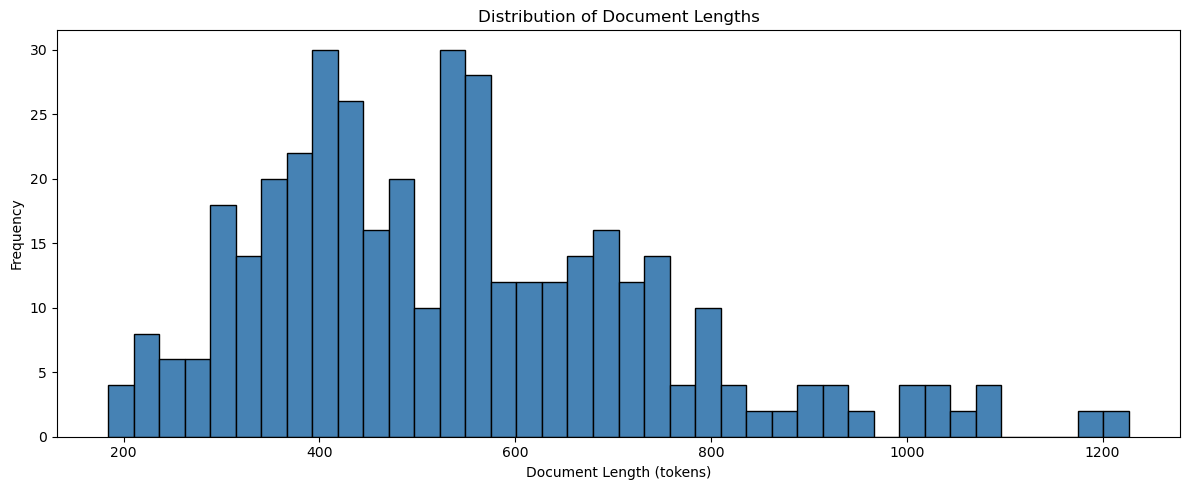


Sample document beginnings:
  Doc 0: A 68- year- old female nonsmoker, nondrinker with a medical history of hypertens...
  Doc 1: A 14- month- old boy was referred to our hospital from another hospital because ...
  Doc 2: Our patient was a 68- year- old woman with chronic obstructive pulmonary disease...
  Doc 3: We present a case of pancreatic tumor without a history of trauma or panceratiti...
  Doc 4: A 41- year- old Caucasian woman underwent a primary double lung transplantation ...


In [33]:
# Check document length distribution
doc_lengths = [len(example['tokens']) for example in train_data]

print("Dataset Heterogeneity:")
print(f"  Document length - Mean: {np.mean(doc_lengths):.0f}, Median: {np.median(doc_lengths):.0f}")
print(f"  Min: {np.min(doc_lengths)}, Max: {np.max(doc_lengths)}")

# Visualize length distribution
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(doc_lengths, bins=40, color='steelblue', edgecolor='black')
ax.set_xlabel('Document Length (tokens)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Document Lengths')
plt.tight_layout()
plt.show()

# Check text style variation (simple heuristic)
print("\nSample document beginnings:")
for i in range(5):
    text = reconstruct_text(train_data[i]['tokens'])
    print(f"  Doc {i}: {text[:80]}...")